# CSCI-UA 0480-042 Computer Vision
## Homework 4

Enter your name and NetID below.

**Name:** Riya Singh

**NetID:** rs6854

The main goals of this assignment include:

- Give an introduction to OpenPose.
- Do body and hand pose estimation using a pretrained OpenPose model.


# 1. Introduction to OpenPose

OpenPose is a real-time multi-person 2D pose detection system. It jointly detects human body, hand, facial, and foot keypoints (in total 135 keypoints) on single images.

GitHub Repo: https://github.com/CMU-Perceptual-Computing-Lab/openpose

Paper: https://arxiv.org/pdf/1812.08008.pdf

The overall pipeline of the detection system is shown in the figure below. 

![](img/pipeline.png)

Given an input image, the model jointly predicts:

(1) **Confidence Maps:** A set of 2d heatmaps of body part locations. Each map is a 2D representation of the belief that a particular body part (neck, shoulder, elbow, etc.) can be located in any given pixel.

(2) **Part Affinity Fields (PAFs):** A set of 2d vector fields that encode body part associations. A pair of body parts form a limb (elbow-shoulder connection). And each PAF is a 2D vector field that encodes the degree of association as well as the direction from one limb part to another.

In the bipartite matching step, body part candidates are matched to form limbs. Each body part could have multiple candidates (multiple people in the image => elbows at multiple locations). The candidate parts need to be associated with other parts from the same person. All candidate limbs are scored using PAFs, and the optimal association for any given pair of body parts is treated as bipartite graph matching problem to generate limb pairs in the entire image. (See figure below)

![](img/part-association.png)

Once we obtain all the limb candidates, all limb connections that share the same part detection candidates can be assembled into fully body poses of multiple people.

## Question 1  [5%]

Briefly explain in 2-3 lines the difference between top-down and bottom-up approaches in pose estimation. Is open pose bottom-up or top-down?

Hint: See page1 of the paper.


**Answer:** A top-down approach detects each person in an image, estimates their body part locations individually, and combines them into a pose. A bottom-up approach detects all body parts in the image and then estimates and groups the parts to determine each person and their pose. In top-down appraoches, the runtime is proportional to the number of people detected in the image while in botton-up approaches the runtime complexity does not depend on the number of people. 


## Question 2 [5%]
Which pretrained network is used in the OpenPose paper to generate features from the image?




**Answer:** In OpenPose, the pretrained network used to generate feature maps is VGG-19 (the first 10 layers).    


## Question 3  [5%]

In multiple pose detection, people often crowd together and this can be problematic because it may result in false associations. In the paper they present a naive solution for finding body part associations where this could occur, and they also briefly explain how PAFs address this problem. Describe briefly what the naive solution is and how PAFs avoid this.

Hint: Read Section 3.4 in the paper.


**Answer:** The naive solution is to use the midpoint between 2 body part types and check for its incidence between candidate part detections. However, there are limitations with this because the orientation of the different body parts relative to each other are lost. PAFs address this problem by preserving both location and orientaion information across the region of support of the limb. They utilize a 2d vector encoding the direction from one body part to the other. Each limb has a PAF joining its 2 associated body parts. 



## Question 4 [5%]
OpenPose network has 2 branches - PAF and confidence map branch. During training, which branch is refined first - PAF or confidence map? What’s the intuition behind this?

Hint: See Section 3.2 in the paper.



**Answer:** The PAF branch is refined first. The intuition behind this is that body part locations can be predicted from the output of PAF channels which are 2d vectors representing the direction and strength of the connection between a pair of body parts. The confidence map output is just the different body parts, so it would be very difficult to parse these into distinct people. 


## Question 5 [5%]
The loss functions used in training use a binary mask for each pixel. Why is this necessary?

Hint: See Section 3.2 in the paper.


**Answer:** A binary mask is necessary in order for the loss to only be calculated for pixels corresponding to a body part and its PAF and ignore background pixels or pixels for other body parts. This avoids penalizing true positive predictions during training. 

# 2. Body Pose Estimation

In this part, we'll try to obtain the body keypoints using a pretrained OpenPose model. There's a [PyTorch version of OpenPose model](https://github.com/Hzzone/pytorch-openpose) which we will be using both in this part and in part 3. 

In [18]:
import cv2
import matplotlib.pyplot as plt

from PIL import Image
from src import util
from src.body import Body, visualize_heatmap, visualize_paf

%matplotlib inline

Let's see the image that was picked for pose detection.

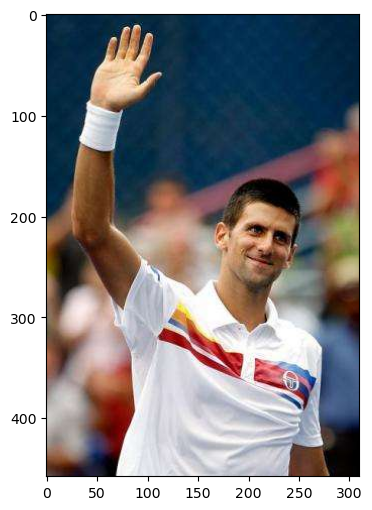

In [19]:
image_path = 'images/demo.jpg'

plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))

Using the pretrained model, let's generate the PAFs and the confidence maps for this image.

In [20]:
image = cv2.imread(image_path)
body_estimation = Body('../shared/data/HW4/model/body_pose_model.pth')
heatmap_avg, paf_avg = body_estimation.get_heatmap_paf(image)

## Question 6 [5%]

Can you show the PAFs? In the resulting plot, you'll see 38 subplots (19 pairs). In each pair, the first and second plots are heatmaps representing the x and y dimensions of the PAF vector field respectively.

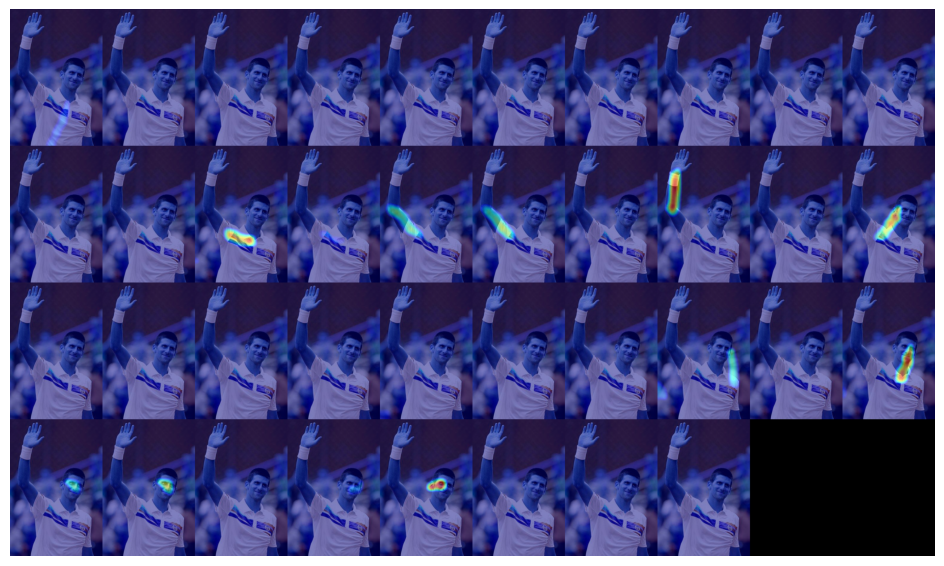

In [21]:
# TODO : Check the code in file src/body.py for the function visualize_paf() and fill in below parameters
visualize_paf(image_path, paf_avg)


## Question 7 [5%]

Can you show the heatmap?

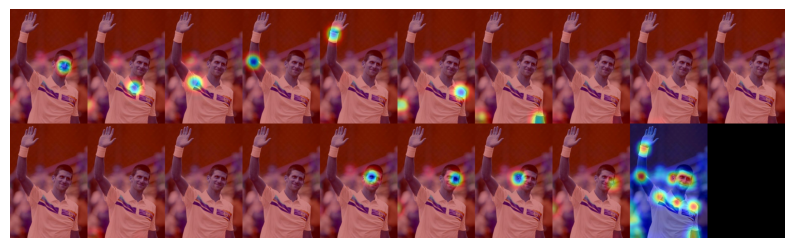

In [22]:
# TODO : Check the code in file src/body.py for the function visualize_heatmap() and fill in below parameters
visualize_heatmap(image_path, heatmap_avg)


## Question 8 [10%]

Using the PAFs and the heatmap, generate the parsing results and show the output.

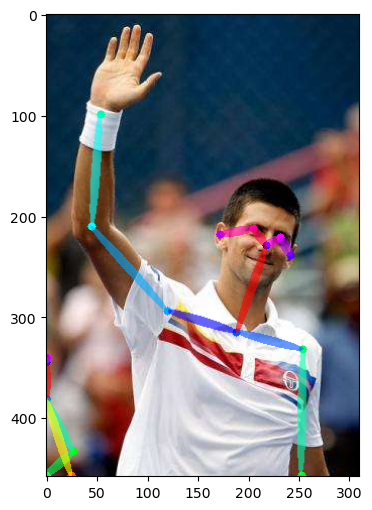

In [23]:
# TODO : Check the code in file src/body.py for the function get_parsing_results() and fill in below parameters
candidate, subset = body_estimation.get_parsing_results(heatmap_avg, paf_avg)

# TODO : Check the code in file src/body.py for the function draw_bodypose() and fill in below parameters
canvas = util.draw_bodypose(image, candidate, subset)

fig = plt.figure(figsize=(6, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])

Let's now check if the model works on a 180-degree rotated image.

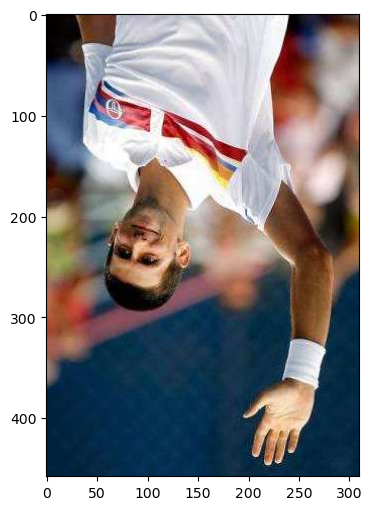

In [24]:
image_path = 'images/demo_180.jpg'

plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))

In [25]:
image = cv2.imread(image_path)
heatmap_avg, paf_avg = body_estimation.get_heatmap_paf(image)

## Question 9 [5%]

Visualize the Part Affinity Fields.

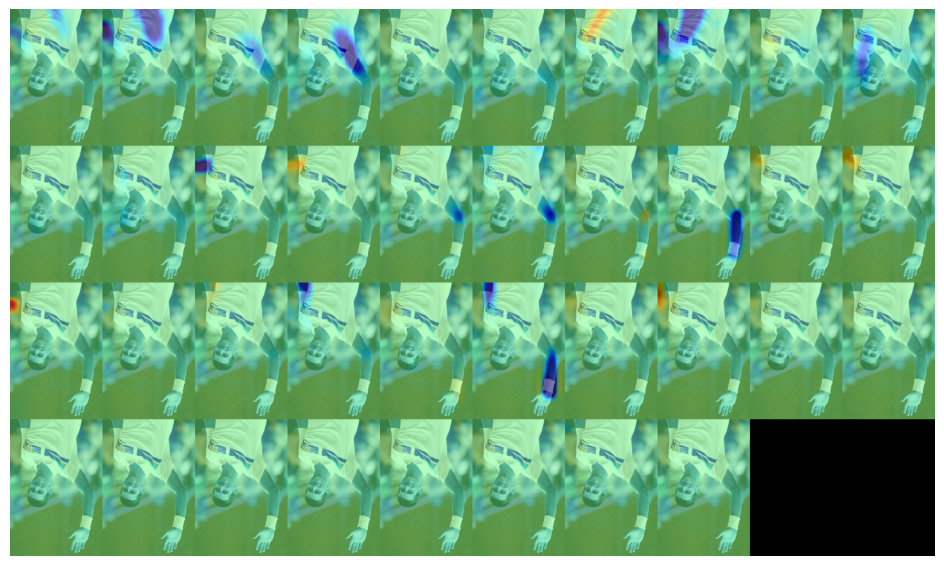

In [26]:
# TODO : Check the code in file src/body.py for the function visualize_paf() and fill in below parameters
visualize_paf(image_path, paf_avg)


## Question 10 [5%]

Show the heatmap.

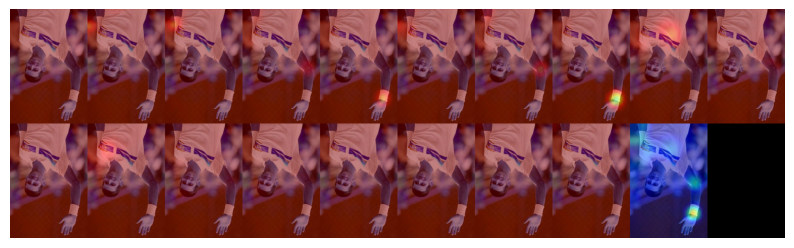

In [27]:
# TODO : Check the code in file src/body.py for the function visualize_heatmap() and fill in below parameters
visualize_heatmap(image_path, heatmap_avg)


## Question 11 [5%]

Using the PAFs and the confidence maps, generate the parsing results and visualize it.

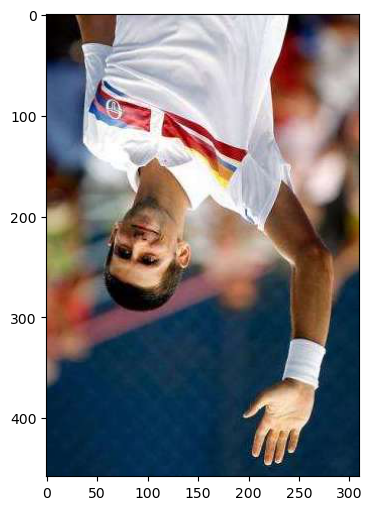

In [28]:
# TODO : Check the code in file src/body.py for the function get_parsing_results() and fill in below parameters
candidate, subset = body_estimation.get_parsing_results(heatmap_avg, paf_avg)

# TODO : Check the code in file src/util.py for the function draw_bodypose() and fill in below parameters
canvas = util.draw_bodypose(image, candidate, subset)

fig = plt.figure(figsize=(6, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])

## Question 12 [5%]

Does the model work on the rotated image? If not, at which stage does it fail?

**Answer:** The model does not appaer to work on the rotated image. After doing some research, it seems that the OpenPose model was trained on people rotated up to 40 degrees, so that may explain why it doesn't work on this 180-degree rotated image may not. When comparing the unrotated and rotated image results, it seems that the PAF fields are similar, but the heatmap for the rotated image seems significantly weaker than the unrotated one. Thus, it may be possible that the model fails at the confidence/heat map stage. 

## Note : Before proceeding further, please restart the kernel without clearing output to free up memory and start fresh for next questions.

# 3. Hand Pose Estimation

Given a hand image, let's try to estimate the hand pose.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from src import util
from src.hand import Hand, visualize_heatmap

%matplotlib inline

Here's the sample image we're going to use.

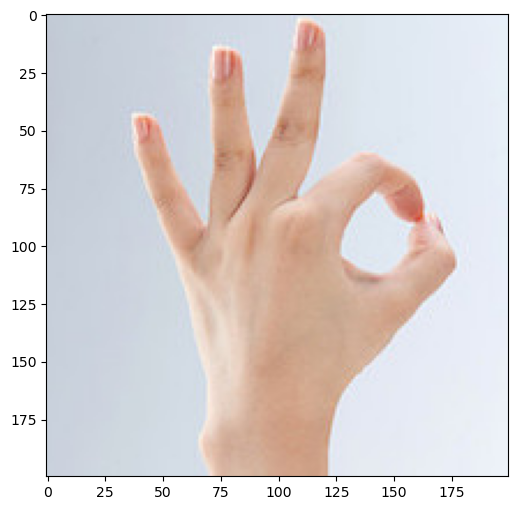

In [3]:
image_path = 'images/hand.jpg'

plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))

Let's generate the heatmap using a pretrained hand pose estimation model.

In [4]:
image = cv2.imread(image_path)  # B,G,R order

hand_model = Hand('../shared/data/HW4/model/hand_pose_model.pth')
heatmap = hand_model.get_heatmap(image)

## Question 13 [5%]

Show the heatmap.

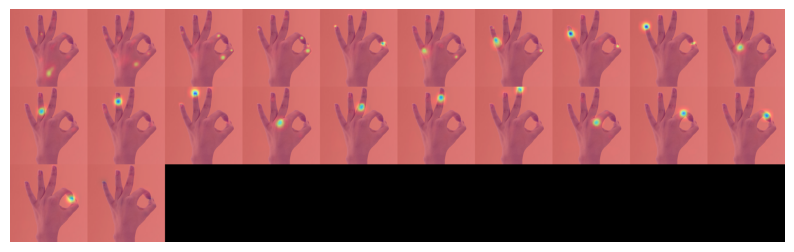

In [5]:
# TODO : Check the code in file src/hand.py for the function visualize_heatmap() and fill in below parameters
visualize_heatmap(image_path, heatmap)

## Question 14 [5%]

Using the heatmap, generate the keypoints (peaks).

In [6]:
# TODO : Check the code in file src/hand.py for the function get_peaks() and fill in below parameters
peaks = hand_model.get_peaks(heatmap)

## Question 15 [5%]

Show the final results.

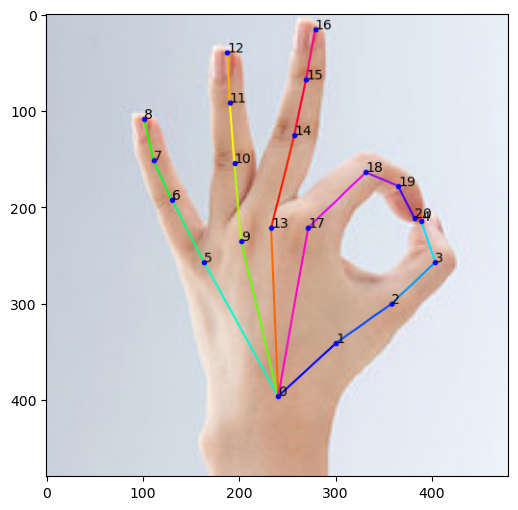

In [7]:
# TODO : Check the code in file src/util.py for the function draw_handpose() and fill in below parameters
canvas = util.draw_handpose(image, peaks, show_number=True)

plt.figure(figsize=(6, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])

Just like before, let's try the hand pose model on a flipped image.

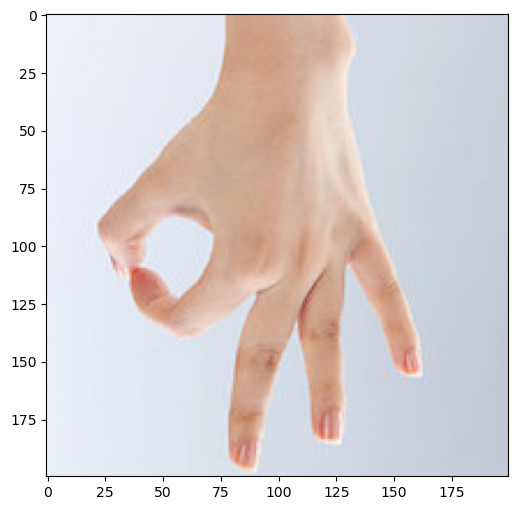

In [8]:
image_path = 'images/hand_180.jpg'

plt.figure(figsize=(6, 6))
plt.imshow(Image.open(image_path))

Now let's generate the heatmap by passing the image through the model.

In [9]:
image = cv2.imread(image_path)  # B,G,R order

hand_model = Hand('../shared/data/HW4/model/hand_pose_model.pth')
heatmap = hand_model.get_heatmap(image)

## Question 16 [5%]

Show the heatmap.

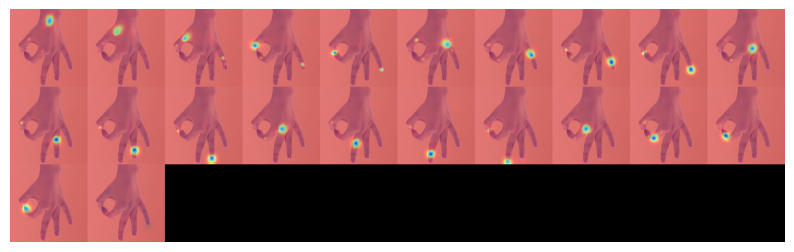

In [10]:
# TODO : Check the code in file src/hand.py for the function visualize_heatmap() and fill in below parameters
visualize_heatmap(image_path, heatmap)

## Question 17 [10%]

Generate the keypoints and show the final output.

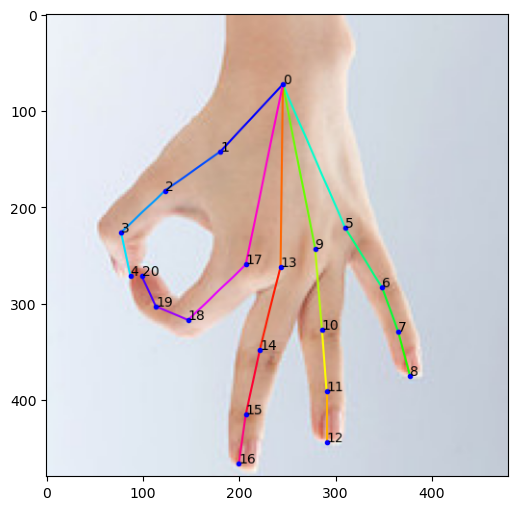

In [11]:
# TODO : Check the code in file src/hand.py for the function get_peaks() and fill in below parameters
peaks = hand_model.get_peaks(heatmap)

# TODO : Check the code in file src/util.py for the function draw_handpose() and fill in below parameters
canvas = util.draw_handpose(image, peaks, show_number=True)

plt.figure(figsize=(6, 6))
plt.imshow(canvas[:, :, [2, 1, 0]])

## Question 18 [5%]

Does the handpose model work on the flipped image? If it doesn't, in which stage does it fail?

**Answer:** Yes, the handpose model appears to have worked on the flipped image. 